# load library

In [1]:
source("r/jupyter_common.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
# data structure
suppressPackageStartupMessages(library(data.table))

# single cell analysis
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(ArchR))


## parallel

In [3]:
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(future))
plan("multicore", workers = 8)

options(future.globals.maxSize = 5 * 1024^3) # 5GB


# parameters

In [4]:
str_condition <- "male-bc"

args <- list()
args$cancer_type <- "male-bc"
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$seurat_resolution <- 0.4
args$harmony_theta <- 0

#str_column_of_meta_data_cluster <- "RNA_snn_res.0.7"
str_column_of_meta_data_cluster <- sprintf("RNA_snn_res.%g", args$seurat_resolution)
str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "cluster.type"

if (args$harmony_theta >= 0) {
    str_column_of_meta_data_cluster <- str_column_of_meta_data_harmony
    str_reduction <- "harmony"
    str_umap_reduction <- "umapharmony"
    col_cluster_types <- "cluster.type.harmony"
}


str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types

figure_format <- "pdf"



[1] "RNA_harmony_th.0"

[1] "umapharmony"

[1] "cluster.type.harmony"

## set.seed

In [5]:
# set seed for reproducibility
set.seed(51)



## display

In [6]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=50)



## nv_cell_type_conversion_table

In [7]:
nv_cell_type_conversion_table <- c(
            "Epi. Tumor"="Epi. Tumor",
            "Epi. Non-tumor"="Epi. CNA-",
            "Normal-like"="Normal-like",
            "Basal"="Basal", "Her2"="Her2", "LumA"="LumA" ,"LumB"="LumB")


# read scRNA-seq

In [8]:
dir_rna <- "/home/hkim77/francolab.w/sc-rna-seq/male-bc/run-20220725"
fname_rna <- sprintf("%s/output_male-bc/rds_male-bc/male-bc_sc-rna-seq_merged_seurat_obj.rds", dir_rna)

rna <- readRDS(fname_rna)


https://mojaveazure.github.io/seurat-object/reference/Seurat-methods.html

dim: The number of features (nrow) and cells (ncol) for the default assay; note: while the number of features changes depending on the active assay, the number of cells remains the same across all assays


## df_cells_celltype_sample

In [9]:
# extract identity and sample information from seurat object to determine the number of cells per cluster per sample
df_cells_celltype_sample <- rna@meta.data[, c(col_cluster_types, "Sample")] %>%
        dplyr::rename(cluster.type = !!col_cluster_types) %>%
        group_by(Sample) %>%
        dplyr::count(cluster.type) %>% 
        tidyr::spread(cluster.type, n) 

# view table
View(t(df_cells_celltype_sample))


Sample,446B7L,4CC61L
0-Epi. Tumor,13,2515
1-Epi. Unassigned,1518,1
2-Epi. Tumor,1396,NA
3-Endothelial cells,1345,2
4-Fibroblasts,493,531
5-Epi. Tumor,422,110
6-Epi. Tumor,269,NA
7-Macrophages,58,198
8-Epi. Unassigned,70,NA


## dt_cells_sample_cluster

In [10]:
# extract meta data
md <- rna@meta.data %>% as.data.table

# count the number of cells per unique combinations of "Sample" and "seurat_clusters"
dt.rna1 <- md[, .N, by = c("Sample", str_column_of_meta_data_cluster)]

# with additional casting after the counting
dt_cells_sample_cluster <- md[, .N, by = c("Sample", str_column_of_meta_data_cluster)] %>% 
    dcast(., sprintf("Sample ~ %s", str_column_of_meta_data_cluster), value.var = "N") %>%
    as.data.table

dt_cells_sample_cluster



Sample,0,1,2,3,4,5,6,7,8
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
446B7L,13,1518,1396,1345,493,422,269,58,70
4CC61L,2515,1,NA,2,531,110,NA,198,NA


In [11]:

dt_cells_sample_cluster[, `:=`(MIN = rowMins(as.matrix(.SD), na.rm=T),
          MAX = rowMaxs(as.matrix(.SD), na.rm=T),
          AVG = rowMeans(.SD, na.rm=T),
          SUM = rowSums(.SD, na.rm=T)), .SDcols=colnames(dt_cells_sample_cluster)[-1]]

dt_cells_sample_cluster

dt_cells_sample <- dt_cells_sample_cluster[, lapply(.SD, sum, na.rm=TRUE),
                        .SDcols=2:ncol(dt_cells_sample_cluster)]

dt_cells_sample


Sample,0,1,2,3,4,5,6,7,8,MIN,MAX,AVG,SUM
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
446B7L,13,1518,1396,1345,493,422,269,58,70,13,1518,620.4444,5584
4CC61L,2515,1,NA,2,531,110,NA,198,NA,1,2515,559.5000,3357


0,1,2,3,4,5,6,7,8,MIN,MAX,AVG,SUM
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
2528,1519,1396,1347,1024,532,269,256,70,14,4033,1179.944,8941


## total_n_cells

In [12]:
sum(dt.rna1$N)


[1] 8941

## mtx

In [13]:
if (DefaultAssay(rna) == "integrated") {
    mtx <- GetAssayData(object = rna, assay=NULL, slot = "data")
} else {
    mtx <- GetAssayData(object = rna, assay="RNA", slot = "data")
}
head(mtx[,1:3])


6 x 3 sparse Matrix of class "dgCMatrix"
           446B7L#AAACCCAAGAGTGTGC-1 446B7L#AAACCCAAGCGACTGA-1
AL627309.1                 .                         .        
AL669831.5                 0.3164787                 0.3594915
FAM87B                     .                         .        
LINC00115                  .                         .        
FAM41C                     .                         .        
AL645608.3                 .                         .        
           446B7L#AAACCCAAGGTAACTA-1
AL627309.1                         .
AL669831.5                         .
FAM87B                             .
LINC00115                          .
FAM41C                             .
AL645608.3                         .

## list_sort

In [14]:
list_sort <- sort_cluster_members(rna, args,
                    col_cluster_types = col_cluster_types,
                    str_umap_reduction = str_umap_reduction,
                    f_merge_immune_cell = FALSE)



Sample,NA,Adipocytes,CD4+ T-cells,CD8+ T-cells,Chondrocytes,DCs,Endothelial cells,Epi. Non-tumor,Epi. Tumor,Epi. Unassigned,Fibroblasts,HSC,Macrophages,Mast cells,Mesangial cells,Monocytes,Myocytes,Pericytes,Smooth muscle
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
446B7L,7,30,NA,1,1,4,1306,164,1647,1865,502,NA,41,NA,2,4,9,1,NA
4CC61L,13,2,1,4,22,26,2,NA,2648,31,503,1,95,2,1,5,NA,NA,1


Sample,NA,Chondrocytes,HSC,Mesangial cells,Myocytes,Pericytes,Smooth muscle
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
446B7L,7,1,NA,2,9,1,NA
4CC61L,13,22,1,1,NA,NA,1


Sample,Adipocytes,CD4+ T-cells,CD8+ T-cells,DCs,Endothelial cells,Epi. Non-tumor,Epi. Tumor,Epi. Unassigned,Fibroblasts,Macrophages,Mast cells,Monocytes,Others
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
446B7L,30,NA,1,4,1306,164,1647,1865,502,41,NA,4,20
4CC61L,2,1,4,26,2,NA,2648,31,503,95,2,5,38


## colors

### samples

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
 [8] "#FF7F00" "#CAB2D6" "#6A3D9A" "#FFFF99" "#B15928" "gold"

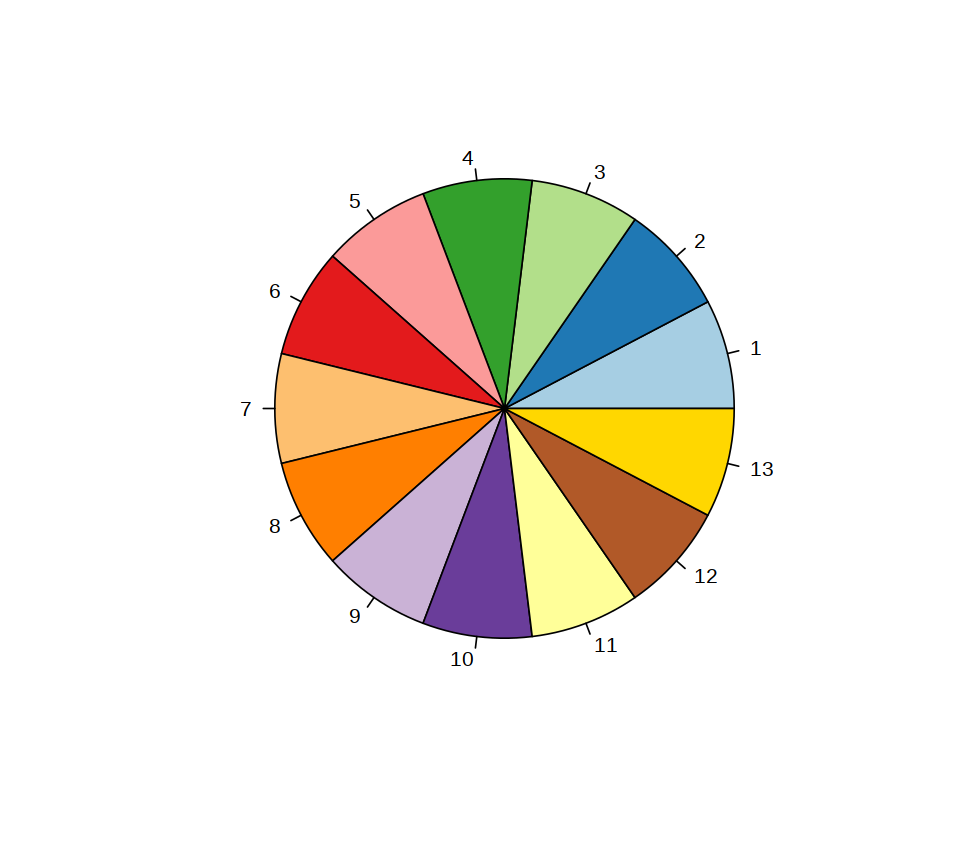

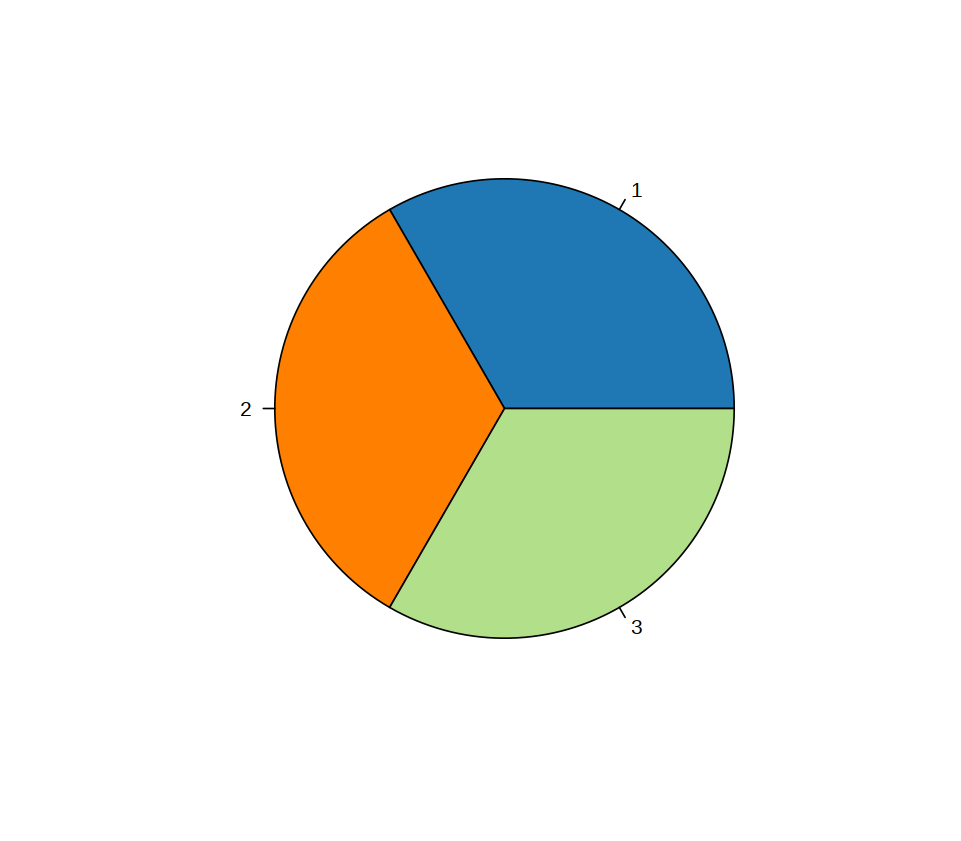

In [15]:
sampleColors0 <- RColorBrewer::brewer.pal(12, "Paired")
sampleColors0[13] <- "gold"
sampleColors0

options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1,length(sampleColors0)), col=sampleColors0) 

sampleColors <- c(sampleColors0[2], sampleColors0[8], rep(sampleColors0[3], 18))
pie(rep(1,3), col=sampleColors) 


### epi

[1] "Epithelial cells" "Epi. Non-tumor"   "LEp_prog"         "LEp_secretory"   
 [5] "LEp"              "LEp_hormone"      "BEp"              "BEp_MaSCs"       
 [9] "BEp_myo"          "Epi. Unassigned"  "Epi. Tumor"       "Normal-like"     
[13] "NBL"              "Basal"            "CLow"             "Her2E"           
[17] "LumA"             "LumB"             "Keratinocytes"

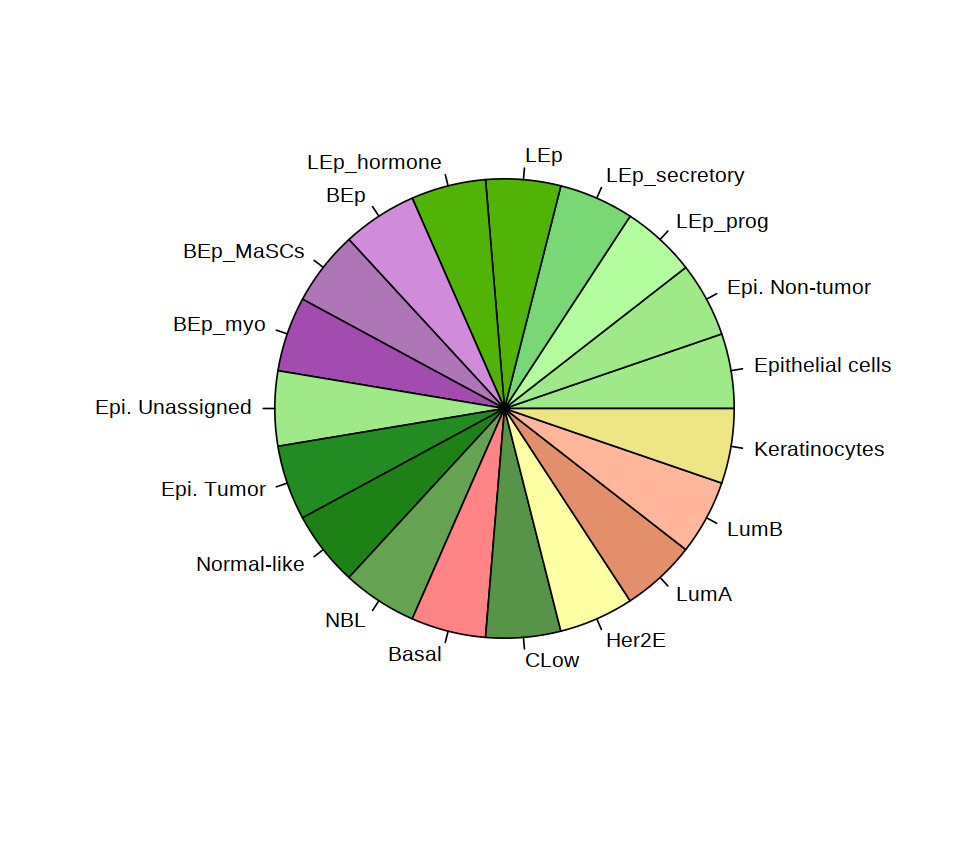

In [16]:
idx_epi <- grep(pattern_epi, names(nv_color))
names(nv_color)[idx_epi]

# http://applied-r.com/rcolorbrewer-palettes/
colors_epi <- RColorBrewer::brewer.pal(9, "Set1")
colors_epi <- colorspace::lighten(colors_epi, amount=0.4)

nv_color["Epi. Unassigned"] <- epithelial.cols[1]
nv_color["Epi. Tumor"] <- "forestgreen"

nv_color["LEp_prog"] <- "#b4fd9e"
nv_color["LEp_secretory"] <- colors_epi[3]
color_lep_mature <- colorspace::darken(nv_color["LEp_prog"], amount=0.3)
nv_color["LEp"] <- color_lep_mature
nv_color["LEp_hormone"] <- color_lep_mature

nv_color["BEp"] <- colors_epi[4]
color_bep_mascs <- colorspace::darken(nv_color["BEp"], amount=0.15)
color_bep_myo <- colorspace::darken(nv_color["BEp"], amount=0.3)
nv_color["BEp_MaSCs"] <- color_bep_mascs
nv_color["BEp_myo"] <- color_bep_myo

nv_color["Basal"] <- colors_epi[1]
nv_color["Her2E"] <- colors_epi[6]
nv_color["Her2"] <- colors_epi[6]
nv_color["LumA"] <- colors_epi[7]
nv_color["LumB"] <- colors_epi[5]
nv_color["Normal-like"] <- colorspace::darken(colors_epi[3], amount=0.4)

pie(rep(1, length(idx_epi)), col=nv_color[idx_epi],
       labels=names(nv_color)[idx_epi]) 

      

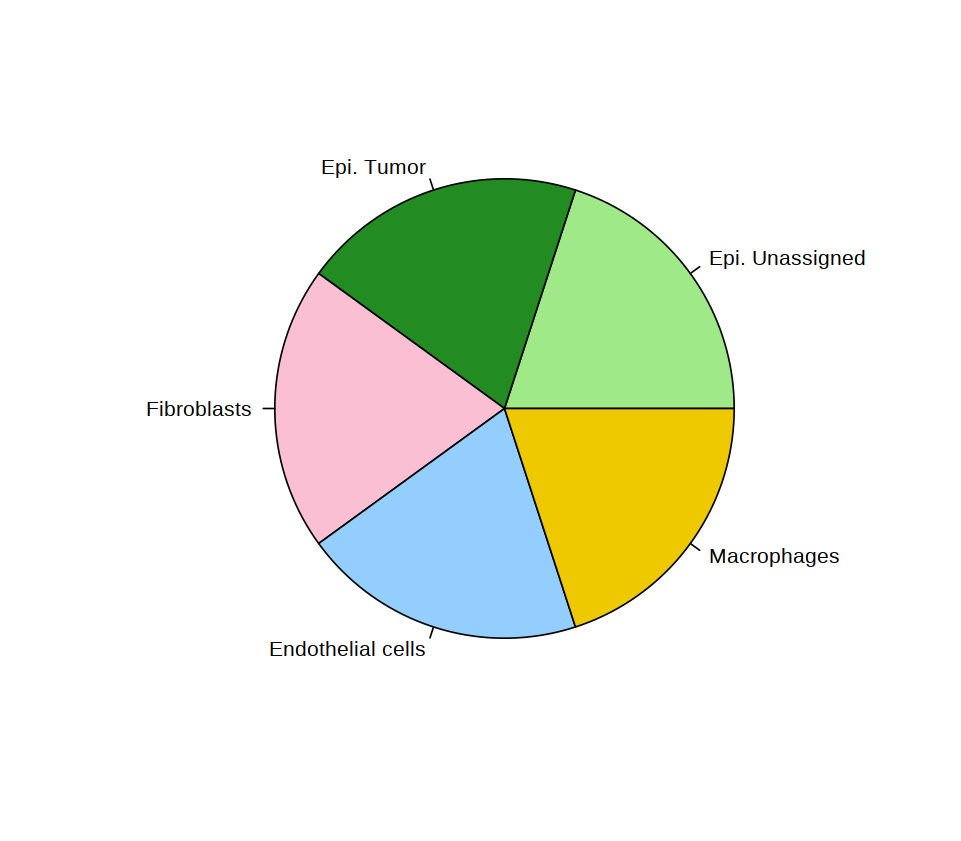

In [17]:
list_sort <- update_nv_color_cell_type(list_sort)
colors_epi <- list_sort$nv_color_cell_type

pie(rep(1, length(colors_epi)), col=colors_epi,
       labels=names(colors_epi)) 


### cell.type

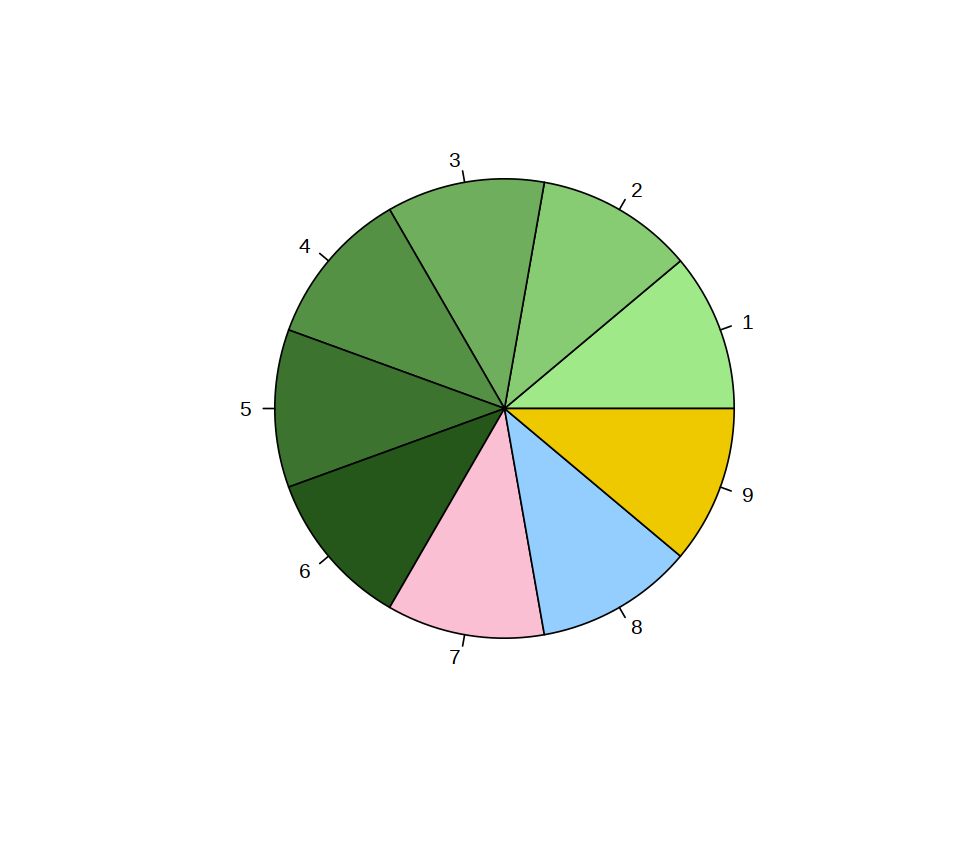

In [18]:
options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1, length(list_sort$nv_color_cluster_type_ordered)),
    col=list_sort$nv_color_cluster_type_ordered) 


# read scATAC-seq

In [19]:
dir_atac <- "/home/hkim77/francolab.w/sc-atac-seq/male-bc/run-20220725"
fname_atac <- sprintf("%s/output_male-bc/rds/male-bc_archrproj_obj_final.rds", dir_atac)

atac <- readRDS(fname_atac)


## meta.data

In [20]:
meta.data <- as.data.frame(getCellColData(atac))


## list_sort_atac

In [21]:

list_sort_atac <- sort_cluster_members(atac, args,
                    col_cluster_types = col_cluster_types,
                    str_umap_reduction = str_umap_reduction,
                    f_merge_immune_cell = FALSE)

list_sort_atac <- update_nv_color_cell_type(list_sort_atac)


Sample,Endothelial cells,Epi. Tumor,Epi. Unassigned,Fibroblasts,Macrophages
<chr>,<int>,<int>,<int>,<int>,<int>
446B7L,2204,1624,1027,1622,183
4CC61L,NA,2629,NA,404,686


Sample
<chr>
446B7L
4CC61L


Sample,Endothelial cells,Epi. Tumor,Epi. Unassigned,Fibroblasts,Macrophages
<chr>,<int>,<int>,<int>,<int>,<int>
446B7L,2204,1624,1027,1622,183
4CC61L,NA,2629,NA,404,686


# UMAPs

## RNA

### patients

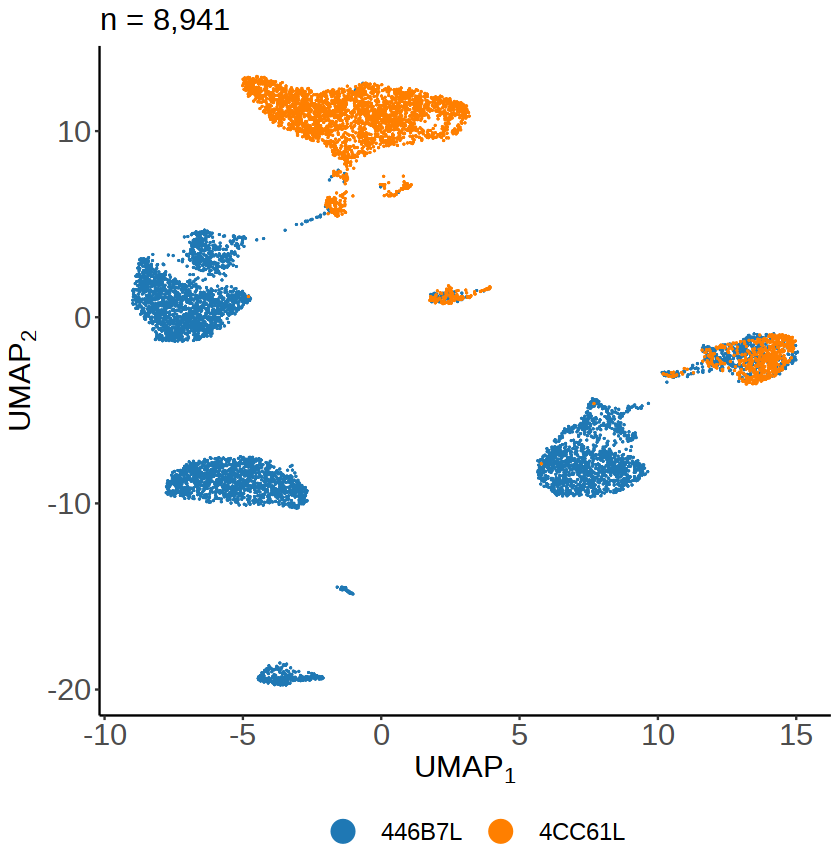

In [22]:
gg <- print_umap_samples(list_sort,
        colors_samples=sampleColors,
        legend.position="bottom",
        ncol=2, str_condition=str_condition)


### cluster labels

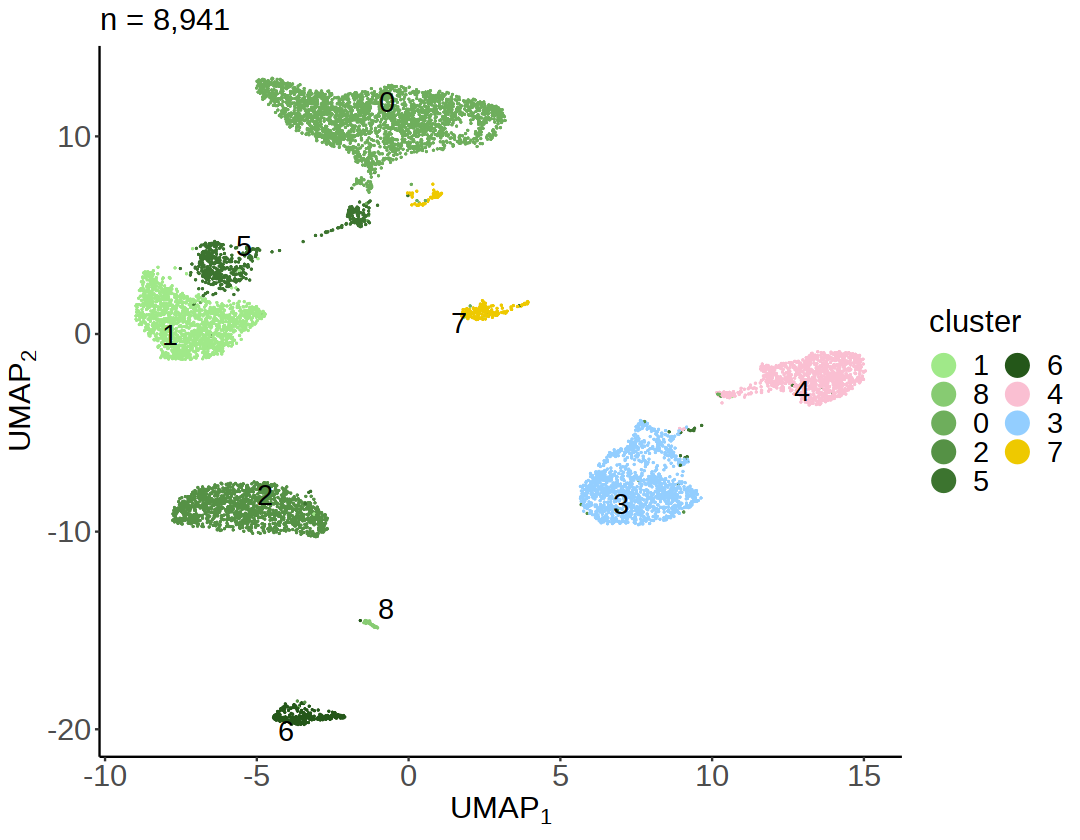

In [23]:
gg <- print_umap_cluster_labels(list_sort,            
            ncol=2, width=9, height=7,
            str_condition=str_condition)


### cluster type

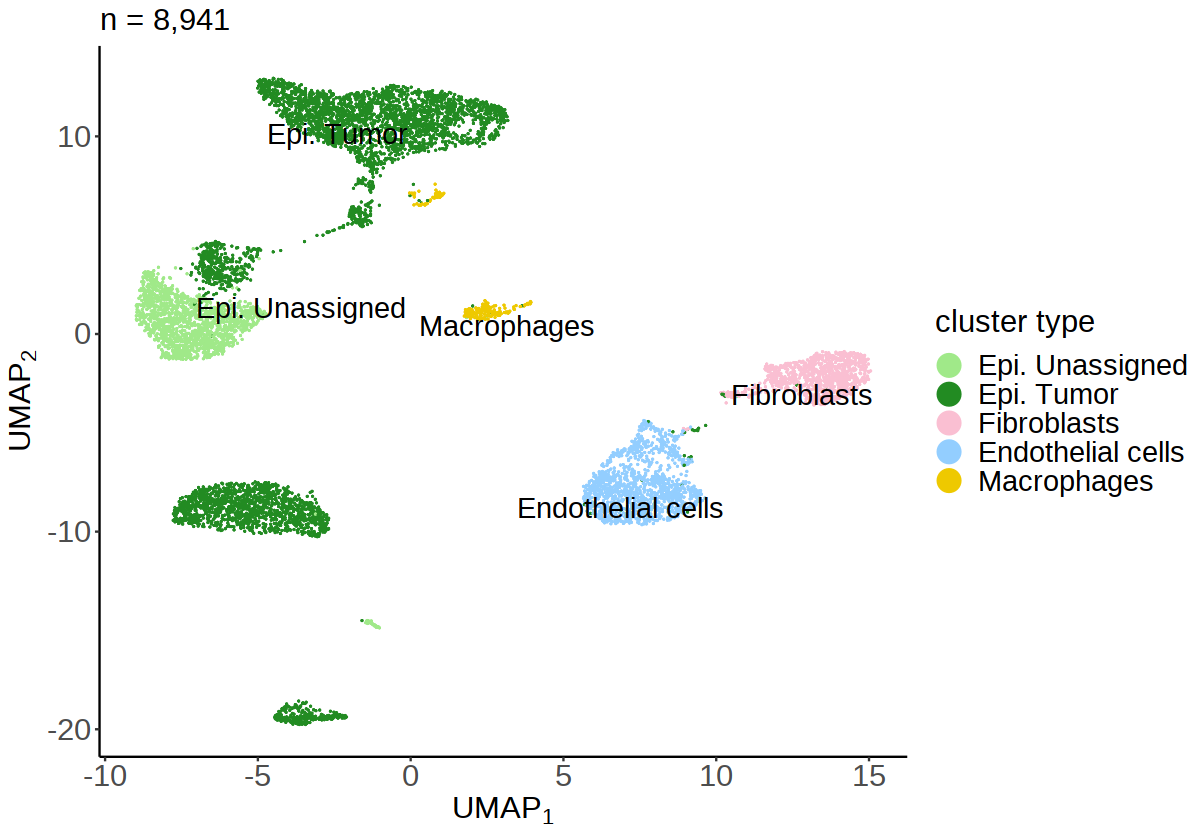

In [24]:
gg.rna.cell.plot <- print_umap_cluster_types(list_sort,
            ncol=1, width=10, height=7,
            str_condition=str_condition)


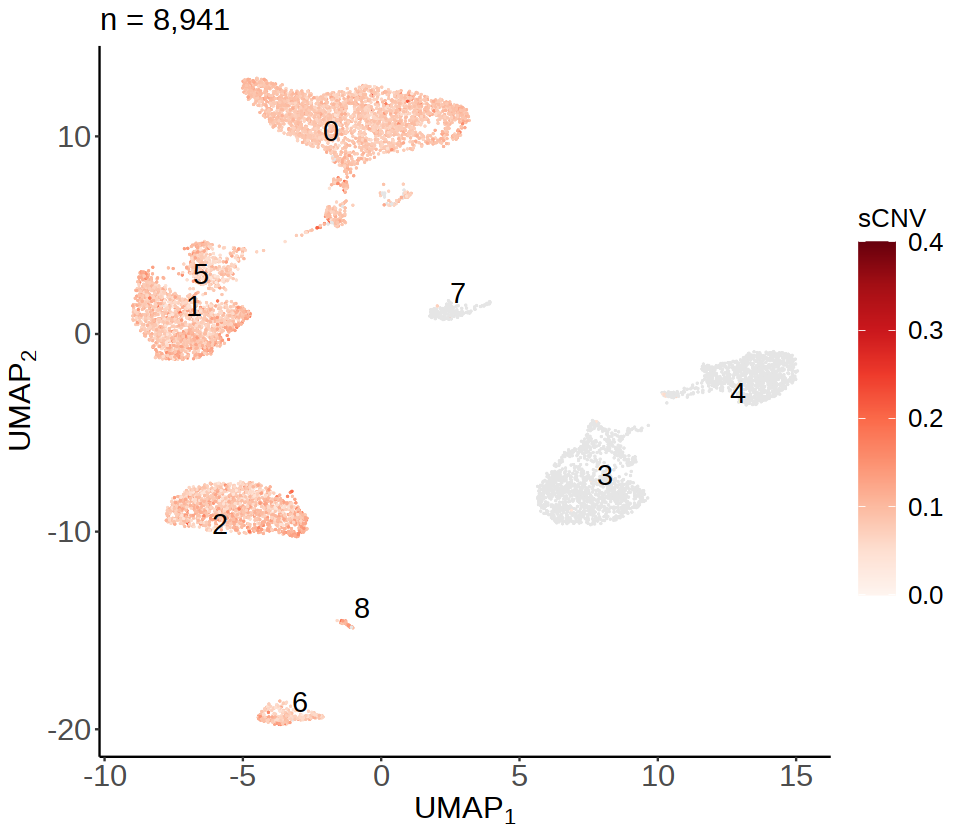

In [25]:

gg <- print_umap_meta.data(rna, list_sort, "CNV.value",
            width=8, height=7,
            str_condition=str_condition)


## ATAC

### pattern_cluster.type_removal

In [26]:
pattern_cluster.type_removal <- "1-|6-|8-"


### patients

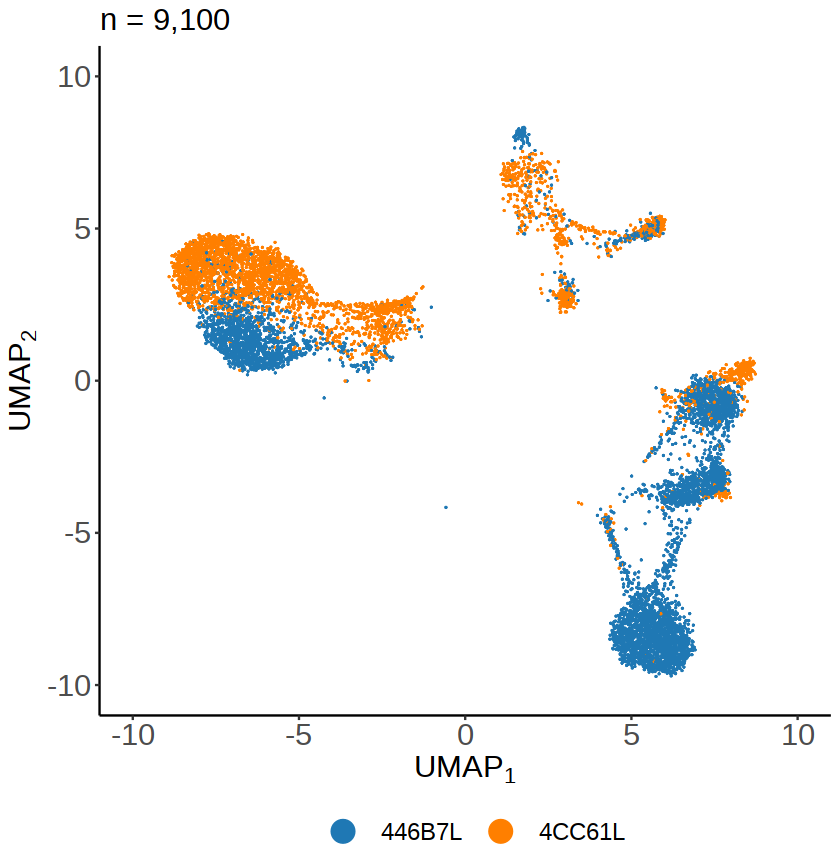

In [27]:

gg <- print_umap_samples(list_sort_atac,
        colors_samples=sampleColors,
        pattern_cluster.type_removal=pattern_cluster.type_removal,
        legend.position="bottom",
        ncol=2, str_condition=str_condition,
        fname_appendix="_atac")



### cluster labels

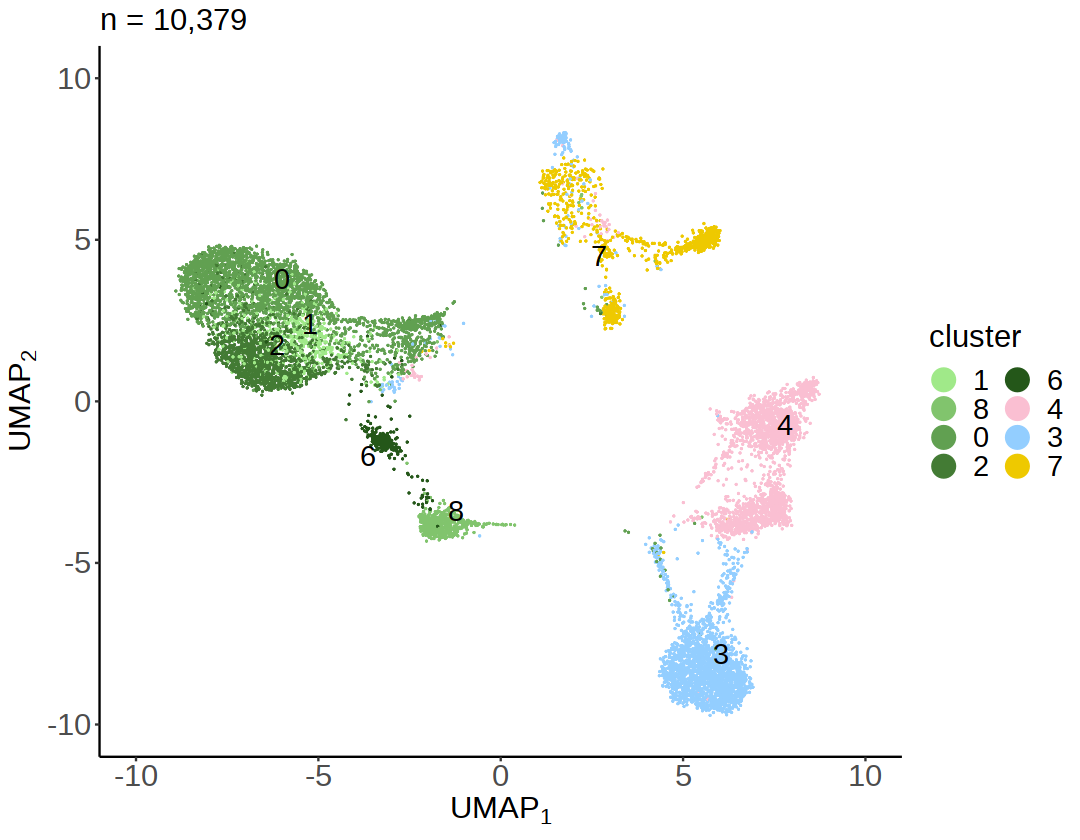

In [28]:

gg <- print_umap_cluster_labels(list_sort_atac,
            ncol=2, width=9, height=7,
            str_condition=str_condition,
            fname_appendix="_atac")


### cluster type

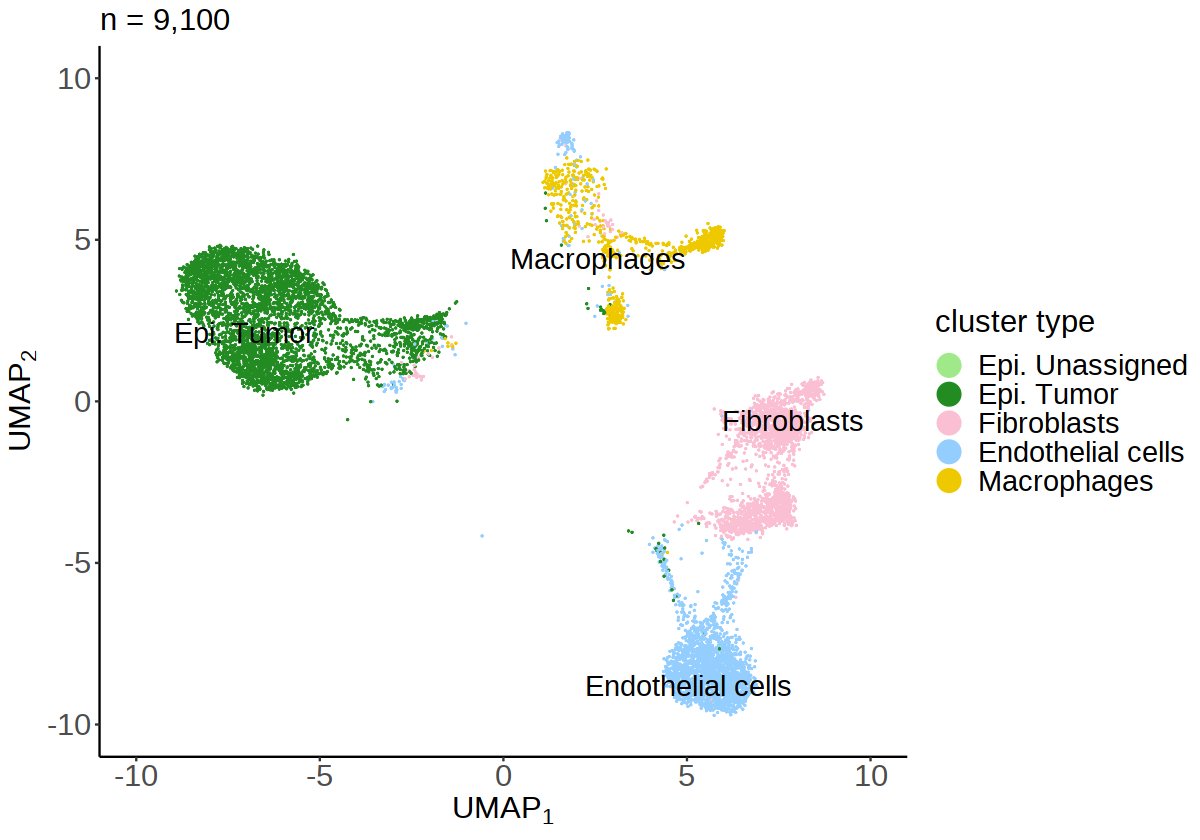

In [29]:

gg <- print_umap_cluster_types(list_sort_atac,
            pattern_cluster.type_removal = pattern_cluster.type_removal,     
            ncol=1, width=10, height=7,
            str_condition = str_condition,
            fname_appendix = "_atac")


# session info

In [30]:
writeLines(capture.output(sessionInfo()), "txt/sessionInfo.txt")


# reference

https://satijalab.org/seurat/
